In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download -d joosthazelzet/lego-brick-images --unzip

Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
License(s): GPL-2.0
 99% 0.99G/1.00G [00:09<00:00, 92.4MB/s]
100% 1.00G/1.00G [00:09<00:00, 117MB/s] 


In [16]:
import kagglehub
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# --------------------
#   Hyperparameters
# --------------------
IMAGE_SIZE = 64       # Input/Output resolution
CHANNELS = 1          # Grayscale = 1, for color use 3
BATCH_SIZE = 128
Z_DIM = 100           # Dim of latent vector
EPOCHS = 3
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NOISE_PARAM = 0.1     # Label smoothing/noise
# --------------------
#   Transforms
# --------------------
# Define the transforms: Grayscale + Resize + Normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Grayscale
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resiz
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Center around 0 with range [-1,1]
])


Normalize the pixel range, usually to [−1,1][−1,1] or [0,1][0,1]. Which one should you  pick here and why ?
We should pick [−1,1][−1,1] because the final output of the generator is [-1,1]

In [8]:
# --------------------
# Dataset & DataLoader
#--------------------

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Gather all image files with .png, .jpg, .jpeg
        self.image_files = sorted([
            f for f in os.listdir(root_dir)
            if f.endswith(('.png', '.jpg', '.jpeg'))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # or "L" for grayscale
        if self.transform:
            image = self.transform(image)
        return image

# Specify your dataset folder path
dataset_path = "./dataset"
dataset = ImageDataset(root_dir=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


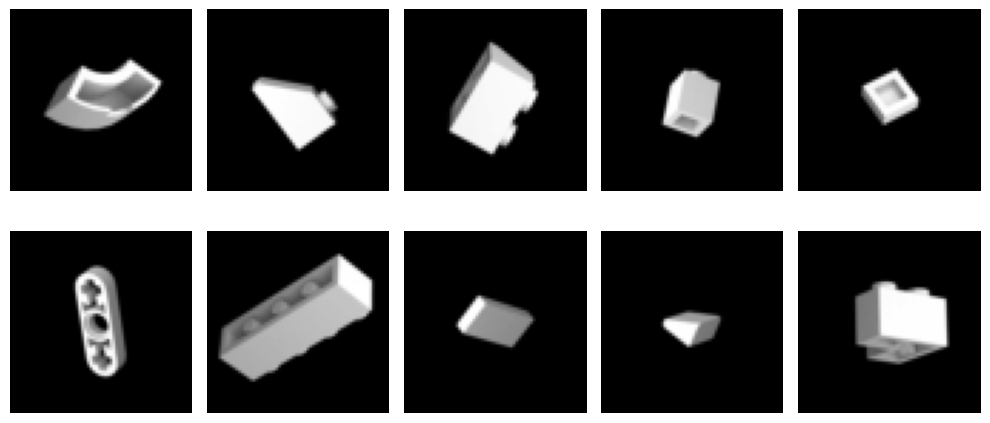

In [9]:
def plot_sample_images(loader):
    data_iter = iter(loader)
    images = next(data_iter)
    images = images.numpy()

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.tight_layout()

plot_sample_images(dataloader)


In [10]:
# ------------------------------
#   Discriminator
# ------------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input shape: (CHANNELS, 64, 64)
            nn.Conv2d(CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # activation function
            nn.Dropout(0.3), #dropout

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),# conv
            nn.BatchNorm2d(128), #batch norm
            nn.LeakyReLU(0.2, inplace=True), # activation function
            nn.Dropout(0.3), #dropout

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # dropout

            # Output shape: (1, 1, 1) -> Flatten to scalar
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),# activation function [0,1]
            nn.Flatten(start_dim=1) # Flatten shape: (batch_size, 1)
        )

    def forward(self, x):
        return self.model(x)


In [13]:
# ------------------------------
#   Generator
# ------------------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: (Z_DIM, 1, 1)
            nn.ConvTranspose2d(Z_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), #norm
            nn.LeakyReLU(0.2, inplace=True), #activatio

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh() # activation function [-1,1]
            # Output shape: (CHANNELS, 64, 64)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate models
critic = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)


In [17]:
#------------------------
#  Losses & Optimizers
#------------------------
criterion = nn.BCELoss()  # Binary Cross Entropy
d_optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

#------------------------
# Training
#------------------------

g_loss_values = []
d_loss_values = []
g_acc_values = []
d_acc_values = []

for epoch in range(EPOCHS):
    g_loss_batch = []
    d_loss_batch = []
    g_acc_batch = []
    d_acc_batch = []

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{EPOCHS}")
    for i, real_images in progress_bar:
        real_images = real_images.to(DEVICE)
        batch_size = real_images.size(0)

        # 1) Train Discriminator
        d_optimizer.zero_grad()

        # True labels near 1, with some noise
        real_labels = torch.ones(batch_size, 1, device=DEVICE)
        real_noisy_labels = real_labels - NOISE_PARAM * torch.rand_like(real_labels)
        # Fake labels near 0, with some noise
        fake_labels = torch.zeros(batch_size, 1, device=DEVICE)
        fake_noisy_labels = fake_labels + NOISE_PARAM * torch.rand_like(fake_labels)

        # Real images
        real_preds = critic(real_images)
        real_loss = criterion(real_preds, real_noisy_labels) #get loss

        # Fake images
        z = torch.randn(batch_size, Z_DIM, 1, 1, device=DEVICE)
        fake_images = generator(z)
        fake_preds = critic(fake_images.detach())
        fake_loss = criterion(fake_preds, fake_noisy_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        # Compute discriminator accuracy
        d_real_acc = (real_preds.round() == real_labels).float().mean().item()
        d_fake_acc = (fake_preds.round() == fake_labels).float().mean().item()
        d_acc = (d_real_acc + d_fake_acc) / 2

        # 2) Train Generator
        g_optimizer.zero_grad()
        fake_preds = critic(fake_images)  # do not detach here
        # Generator wants D to say "real" => label=1
        g_loss = criterion(fake_preds, real_labels)
        g_loss.backward()
        g_optimizer.step()

        g_acc = (fake_preds.round() == real_labels).float().mean().item()

        # Track batch losses & accuracy
        d_loss_batch.append(d_loss.item())
        g_loss_batch.append(g_loss.item())
        d_acc_batch.append(d_acc)
        g_acc_batch.append(g_acc)

        progress_bar.set_postfix(D_Loss=d_loss.item(), G_Loss=g_loss.item())

    # End of epoch: record average metrics
    d_loss_values.append(np.mean(d_loss_batch))
    g_loss_values.append(np.mean(g_loss_batch))
    d_acc_values.append(np.mean(d_acc_batch))
    g_acc_values.append(np.mean(g_acc_batch))

    # Occasionally save sample images
    if (epoch + 1) % 10 == 0:
        # Generate sample images
        with torch.no_grad():
            z_sample = torch.randn(16, Z_DIM, 1, 1, device=DEVICE)
            fake_sample = generator(z_sample).cpu()
        # Save or display using torchvision.utils
        vutils.save_image(fake_sample, f"fake_sample_epoch_{epoch+1:03d}.png", normalize=True)



Epoch 3/3: 100%|██████████| 313/313 [02:36<00:00,  2.00it/s, D_Loss=0.594, G_Loss=0.998]


In [19]:
# Load state dictionaries
CRITIC_PATH= './tp2-1_simple_discriminator.pth'
GEN_PATH= './tp2-1_simple_generator.pth'
generator.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
critic.load_state_dict(torch.load(CRITIC_PATH, map_location=DEVICE))
generator.eval()
critic.eval()

<ipython-input-19-ad8f74a7d1b3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
<ipython-input-19-ad8f7

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14

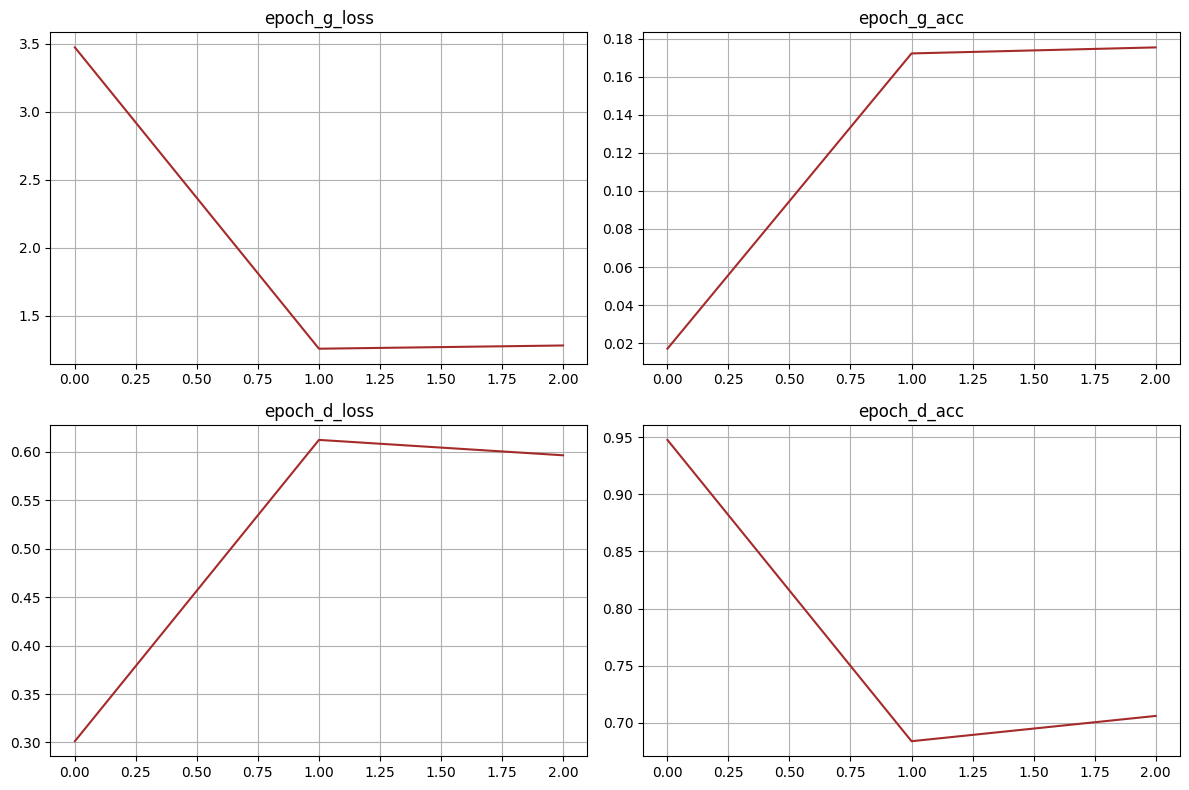

In [20]:
#--------------------------
#  Plotting Results
#--------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

titles = ['epoch_g_loss', 'epoch_g_acc', 'epoch_d_loss', 'epoch_d_acc']
data = [g_loss_values, g_acc_values, d_loss_values, d_acc_values]

for ax, title, values in zip(axes, titles, data):
    ax.plot(values, color='brown')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()


What do you observe ? What's wrong ?
Le générateur semble échouer avec une perte faible et une faible précision, tandis que le discriminateur domine avec une forte précision initiale.

If the discriminator loss is near zero but the generator loss is large, what does that imply?
Une perte du discriminateur proche de zéro et une perte du générateur élevée indiquent que le discriminateur est trop puissant, empêchant le générateur d'apprendre efficacement.


What does “mode collapse” look like?
Cela se traduit par des images générées presque identiques, avec peu ou pas de diversité.


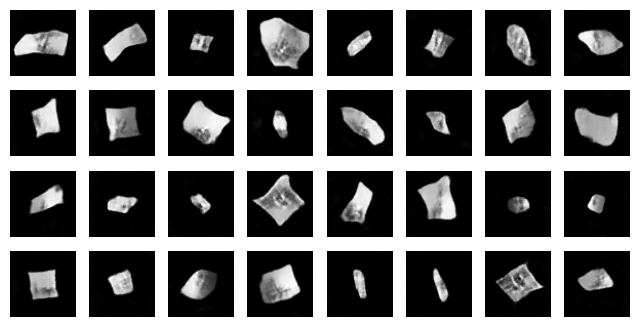

In [21]:
#--------------------------
#  Sampling
#--------------------------
# Generate a grid of images from random noise
grid_width, grid_height = (8, 4)
z_sample = torch.randn(grid_width * grid_height, Z_DIM, 1, 1, device=DEVICE)
gen_imgs = generator(z_sample).cpu().detach()

# Show them in a matplotlib grid
fig = plt.figure(figsize=(grid_width, grid_height))
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    # Each image shape: (1, 64, 64)
    ax.imshow(gen_imgs[i, 0, :, :], cmap="gray")
plt.show()
